# Experiment 3

This notebook contains the experiment to investigates the question **How long should the current most restrictive measures have to continue, as of April 12?**, which is reported on Figure 4 in the [paper](https://arxiv.org/abs/2004.07641).

The notebook is organized as follows:

* In Section 1, we define all the simulation parameters.
* In Section 2, we run all the simulations needed for the experiment.
* In Section 3, we plot the results.

To just regenerate the figures from a summary file containing all the simulation objects of the experiment, you can skip Section 2, and only run the cells in Sections 1 & 3. 

---

## 1. Define the experiment parameters

#### Import libs

In [20]:
import numpy as np
import pickle
import multiprocessing

In [21]:
from lib.mobilitysim import MobilitySimulator
from lib.parallel import launch_parallel_simulations
from lib.distributions import CovidDistributions
from lib.data import collect_data_from_df
from lib.measures import (MeasureList, Interval,
                          BetaMultiplierMeasureByType,
                          SocialDistancingForAllMeasure, 
                          SocialDistancingForPositiveMeasure)

#### Set the random seed for reproducibility

In [22]:
# Choose random seed
c = 0
# Set it
np.random.seed(c)
# Define prefix string used to save plots
runstr = f'run{c}_'  

#### Set the number of roll-outs to simulate

In [23]:
random_repeats = 2

#### Define the number of parallel workers used for simulations 

In [24]:
num_workers = multiprocessing.cpu_count() - 1

#### Set the time to simulate

In [25]:
days_present = 35  # Days since March 10 on April 12 (March 10 is time 0 for our experiments)
days_future = 12 * 7  # Projecting 12 weeks into the future
max_time_future = 24.0 * days_future  # in hours

#### Define population/mobility parameters

Import downsampled version of Tübingen (population downsampled by 20x, sites by 10x) that was used used to generate mobility traces on the fly for inference (sites, home locations, etc)

In [26]:
case_downsample = 10                       # Downsample of population
mob_settings = 'lib/tu_settings_20_10.pk'  # Mobility settings (should match `case_downsample`)
town_name = 'LK Tübingen'                  # Name of town to fetch case data

# See town-generator.ipynb for an example on how to create the settings
with open(mob_settings, 'rb') as fp:
    obj = pickle.load(fp)
mob = MobilitySimulator(**obj)

#### Load the case data

We adjust the number of cases to the down-scaling of the population

In [27]:
new_cases_ = collect_data_from_df(town_name, 'new', until=days_present)
resistant_cases_ = collect_data_from_df(town_name, 'recovered', until=days_present)
fatality_cases_ = collect_data_from_df(town_name, 'fatality', until=days_present)

# fatality rate per age group
num_age_groups = fatality_cases_.shape[1] 
fatality_rates_by_age = (fatality_cases_[-1, :] / \
    (new_cases_[-1, :] + fatality_cases_[-1, :] + resistant_cases_[-1, :]))
print('Empirical fatality rates per age group:  ', fatality_rates_by_age.tolist())

# Instantiate correct state transition distributions (estimated from in literature)
distributions = CovidDistributions(fatality_rates_by_age=fatality_rates_by_age)

# Scale down cases based on number of people in simulation
new_cases, resistant_cases, fatality_cases = (
    1/case_downsample * new_cases_, 
    1/case_downsample * resistant_cases_, 
    1/case_downsample * fatality_cases_)
new_cases, resistant_cases, fatality_cases = np.ceil(new_cases), np.ceil(resistant_cases), np.ceil(fatality_cases)

Data last updated at:  13.04.2020, 00:00 Uhr
Data last updated at:  13.04.2020, 00:00 Uhr
Data last updated at:  13.04.2020, 00:00 Uhr
Empirical fatality rates per age group:   [0.0, 0.0, 0.0, 0.001430615164520744, 0.00964630225080386, 0.11728395061728394]


#### Define initial seed count per state 

These numbers are based on the *downscaled* infection counts on April 12.

In [28]:
present_seeds = {
    'expo': 3,
    'ipre': 1,
    'iasy': 0,
    'isym_notposi': 8,
    'isym_posi': 4,
    'resi_notposi': 78,
    'resi_posi': 110,
}

#### Set epidemic parameters

Inferred using Bayesian optimization.

In [29]:
inferred_params = {
    'betas': [1.1383] * 5,  # site infectivity by type
    'alpha': 0.3224,
    'mu': 0.2072
}

#### Define standard testing parameters

The parameters are the same used for inference.

In [30]:
def standard_testing(max_time):
    standard_testing_params = {
        'testing_t_window'    : [0.0, max_time], # in hours
        'testing_frequency'   : 24.0,     # in hours
        'test_reporting_lag'  : 48.0,     # in hours (actual and self-report delay)
        'tests_per_batch'     : 10,       # assume 300 tests/day in LK Tübingen
        'test_smart_delta'    : 24.0 * 3, # in hours
        'test_smart_duration' : 24.0 * 7, # in hours
        'test_smart_action'   : 'isolate', 
        'test_smart_num_contacts'   : 10, 
        'test_targets'        : 'isym',
        'test_queue_policy'   : 'fifo',
        'smart_tracing'       : None, 
    }
    return standard_testing_params

#### Define helper I/O functions to load/save the output of the experiment

In [31]:
def save_summary(summary, filename):
    with open('summaries/' + filename, 'wb') as fp:
        pickle.dump(summary, fp)
    
def load_summary(filename):
    with open('summaries/' + filename, 'rb') as fp:
        summary = pickle.load(fp)
    return summary

---

## 2. Run the simulations

Define a helper function to run general type of experiment, fixing all parameters above.


In [13]:
def run(tparam, measure_list, t, local_seeds):

    # add standard measure of positives staying isolated
    measure_list +=  [
        SocialDistancingForPositiveMeasure(
            t_window=Interval(0.0, t), p_stay_home=1.0)
    ]
    measure_list = MeasureList(measure_list)

    # run simulations
    summary = launch_parallel_simulations(
        mob_settings, 
        distributions, 
        random_repeats, num_workers, 
        inferred_params, local_seeds, tparam, measure_list, 
        max_time=t, 
        num_people=mob.num_people, 
        num_sites=mob.num_sites, 
        site_loc=mob.site_loc, 
        home_loc=mob.home_loc, verbose=False)
    return summary
    

Run the experiment using the parameters defined above and simulate in the future, with additional measures of varying duration.

**WARNING: this cell might take a long time to run depending of the parameters defined above!**

In [14]:
tuned_p_stay_home = 0.55
tuned_site_multipliers = [0.0, 0.0, 1.0, 1.0, 1.0]

continue_for_weeks_SD_2 = [1, 2, 4, 8]
testing_params_SD_2 = standard_testing(max_time_future)
summaries_SD_2 = []

for j, w in enumerate(continue_for_weeks_SD_2):
    print(f'Run measure type {j+1}/{len(continue_for_weeks_SD_2)}... ', end='', flush=True)
    
    # same as tuned before but continued for longer
    m = [BetaMultiplierMeasureByType(
            t_window=Interval(0.0, (24.0 * 7 * w)), 
            beta_multiplier=tuned_site_multipliers),

         SocialDistancingForAllMeasure(
            t_window=Interval(0.0, (24.0 * 7 * w)), 
            p_stay_home=tuned_p_stay_home)
    ] 

    res = run(testing_params_SD_2, m, max_time_future, present_seeds) 
    summaries_SD_2.append(res)
    print('done.', flush=True)

save_summary(summaries_SD_2, 'summaries_SD_2.pk')

Run measure type 1/4... done.
Run measure type 2/4... done.
Run measure type 3/4... done.
Run measure type 4/4... done.


---

## 3. Plot the results

Import libs

In [32]:
from lib.plot import Plotter

Load the summary holding the results of the experiment to plot.

In [33]:
continue_for_weeks_SD_2 = [1, 2, 4, 8]
summaries_SD_2 = load_summary('summaries_SD_2.pk')

Reproduce Figure 4 in the paper.

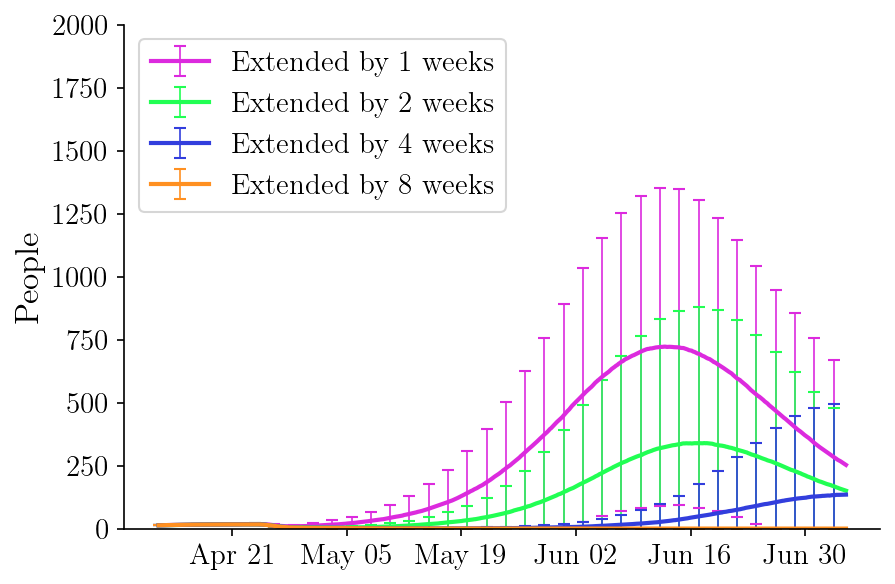

In [34]:
plotter = Plotter()
plotter.compare_total_infections(
    summaries_SD_2, 
    titles=[f'Extended by {w} weeks' for w in continue_for_weeks_SD_2], 
    figtitle='',
    start_date='2020-04-12',
    filename=runstr + 'SD_030', 
    figsize=(6,4), acc=500, 
    legend_is_left=True,
    ymax=2000, errorevery=14)

R_t figure (not in the paper)

In [19]:
# Best values found by MLE for the variance parameter sigma of the Prior
# best_sigmas = [0.22, 0.18, 0.05, 0.05]

# plotter = Plotter()
# plotter.plot_daily_rts(
#     summaries_SD_2,
#     filename=runstr + f'SD2_003',
#     titles=[f'Extended by {w} weeks' for w in continue_for_weeks_SD_2], 
#     colors=plotter.color_different_scenarios,
#     start_date='2020-04-12',
#     sigma=best_sigmas, 
#     fill_between=False,
#     draw_dots=False,
#     figsize=(6, 4),
#     errorevery=2,
#     show_legend=True,
#     xtick_interval=2,
#     ymax=4.0)

TypeError: 'NoneType' object is not subscriptable